<a href="https://colab.research.google.com/github/amirmafzali/Neural_network-and-deep-learning_course/blob/main/Semantic%20segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q datasets transformers evaluate

In [2]:
from datasets import load_dataset
import json
from huggingface_hub import cached_download, hf_hub_url
from transformers import AutoImageProcessor, BeitForSemanticSegmentation
import evaluate
import torch
from torch import nn
import numpy as np
from transformers import TrainingArguments, Trainer
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
ds = load_dataset("scene_parse_150", split="train[:5]")
ds = ds.train_test_split(test_size=0.2)
train_ds = ds["train"]
test_ds = ds["test"]

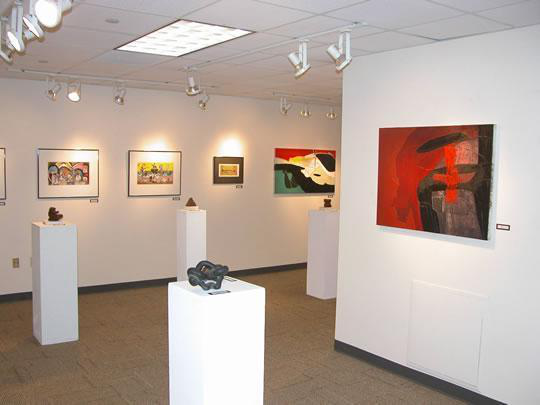

In [18]:
img = train_ds[0]['image']
img

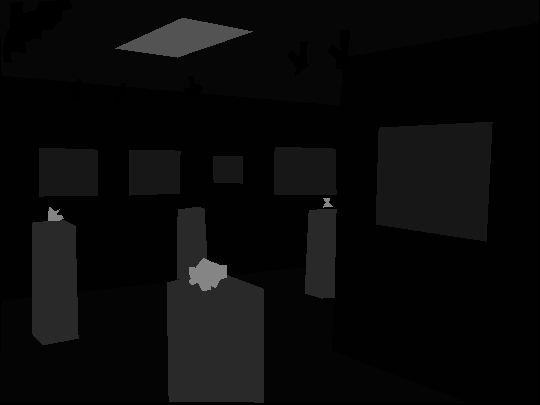

In [19]:
train_ds[0]['annotation']

In [ ]:
feature_extractor = AutoImageProcessor.from_pretrained("microsoft/beit-base-finetuned-ade-640-640", reduce_labels=True)

In [21]:
def transforms(example_batch):
    images = [x for x in example_batch["image"]]
    labels = [x for x in example_batch["annotation"]]
    inputs = feature_extractor(images, labels)
    return inputs

In [22]:
train_ds.set_transform(transforms)
test_ds.set_transform(transforms)

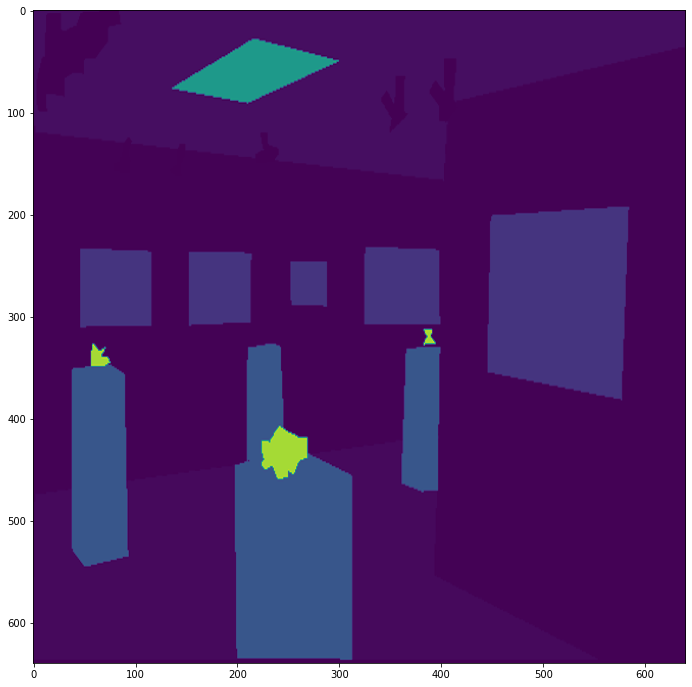

In [23]:
plt.figure(figsize=(16, 12))
plt.imshow(train_ds[0]['labels'])

In [ ]:
repo_id = "huggingface/label-files"
filename = "ade20k-id2label.json"
id2label = json.load(open(cached_download(hf_hub_url(repo_id, filename, repo_type="dataset")), "r"))
id2label = {int(k): v for k, v in id2label.items()}
label2id = {v: k for k, v in id2label.items()}
num_labels = len(id2label)

In [25]:
model = BeitForSemanticSegmentation.from_pretrained("microsoft/beit-base-finetuned-ade-640-640", 
                                                    id2label=id2label, label2id=label2id,
                                                    ignore_mismatched_sizes=True)

In [26]:
encoding = feature_extractor(img, return_tensors="pt")
pixel_values = encoding.pixel_values

In [27]:
outputs = model(pixel_values=pixel_values)
logits = outputs.logits

In [28]:
upsampled_logits = nn.functional.interpolate(
    logits,
    size=img.size[::-1],
    mode="bilinear",
    align_corners=False,
)

pred_seg = upsampled_logits.argmax(dim=1)[0]

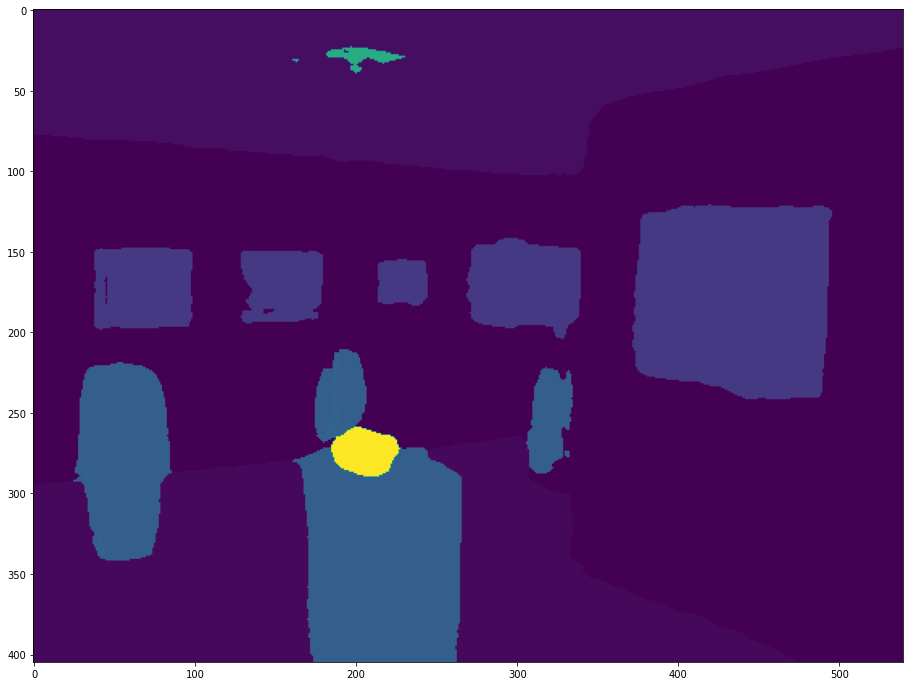

In [29]:
plt.figure(figsize=(16, 12))
plt.imshow(pred_seg)

In [30]:
metric = evaluate.load("mean_iou")

def compute_metrics(eval_pred):
    with torch.no_grad():
        logits, labels = eval_pred
        logits_tensor = torch.from_numpy(logits)
        logits_tensor = nn.functional.interpolate(
            logits_tensor,
            size=labels.shape[-2:],
            mode="bilinear",
            align_corners=False,
        ).argmax(dim=1)

        pred_labels = logits_tensor.detach().cpu().numpy()
        metrics = metric.compute(
            predictions=pred_labels,
            references=labels,
            num_labels=num_labels,
            ignore_index=255,
            reduce_labels=False,
        )
        for key, value in metrics.items():
            if type(value) is np.ndarray:
                metrics[key] = value.tolist()
        return metrics

In [ ]:
training_args = TrainingArguments(
    output_dir="segformer-b0-scene-parse-150",
    save_strategy="epoch",
    evaluation_strategy="epoch",
    learning_rate=2e-4,
    per_device_train_batch_size=10,
    per_device_eval_batch_size=4,
    num_train_epochs=50,
    weight_decay=0.01,
    load_best_model_at_end=True,
    logging_dir='logs',
    remove_unused_columns=False,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics,
)

trainer.train()

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 4
  Num Epochs = 50
  Instantaneous batch size per device = 10
  Total train batch size (w. parallel, distributed & accumulation) = 10
  Gradient Accumulation steps = 1
  Total optimization steps = 50
  Number of trainable parameters = 163407980
